# Whitening
Whitening is a preprocessing step used in training images to reduce correlation between adjacent pixels. This preprocessing step has been shown to improve performance by allowing algorithms to focus on the underlying structure in the images.

The brainlit implementation of PCA and ZCA whitening is based off of http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

I compare the results to existing implementations (sklearn for PCA and keras for ZCA). These implementations train covariances across multiple images. However, given the nature of the Brainlit's task (segmentation of large volumes), we are more interested examining covariances across patches of a larger volume. The extra steps to accomplish this are built into Brainlit's implementation

In [1]:
import numpy as np
import brainlit.preprocessing as preprocessing
from skimage import data
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA

Using TensorFlow backend.


# PCA Whitening

The sklearn implementation is visually similar to the brainlit implementation. However, the colors are inverted relative to each other, which can easily be corrected. 

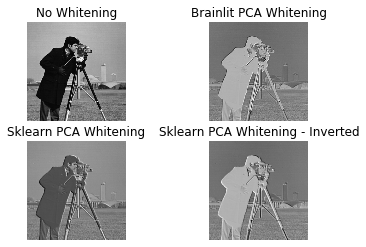

In [21]:
img = data.camera()
step_size = np.array([1,1])
window_size = np.array([5,5])

img_padded, pad_size = preprocessing.window_pad(img, window_size, step_size)
img_vectorized = np.transpose(preprocessing.vectorize_img(img_padded, window_size, step_size))

pca = PCA(whiten=True)
sklearn_whitened = pca.fit_transform(img_vectorized)
sklearn_whitened = preprocessing.imagize_vector(np.transpose(sklearn_whitened), img_padded.shape, window_size, step_size)
sklearn_whitened = preprocessing.undo_pad(sklearn_whitened, pad_size)
sklearn_normalized = 256*(sklearn_whitened - np.min(sklearn_whitened))/(np.max(sklearn_whitened)-np.min(sklearn_whitened))

brainlit_whitened, _ = preprocessing.whiten(img, window_size, step_size, centered=False, type='PCA')
brainlit_normalized = 256*(brainlit_whitened - np.min(brainlit_whitened))/(np.max(brainlit_whitened)-np.min(brainlit_whitened))

plt.figure()
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.title("No Whitening")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(brainlit_normalized, cmap='gray')
plt.title("Brainlit PCA Whitening")
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(sklearn_normalized, cmap='gray')
plt.title("Sklearn PCA Whitening")
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(255-sklearn_normalized, cmap='gray')
plt.title("Sklearn PCA Whitening - Inverted")
plt.axis('off')
plt.show()

The results are not exactly the same, however if we examine the average error per pixel:

In [26]:
print(np.sum(np.abs((255-sklearn_normalized) - brainlit_normalized))/512**2)

10.465291391044799


# ZCA Whitening

ZCA whitening is implemented in Keras.

/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


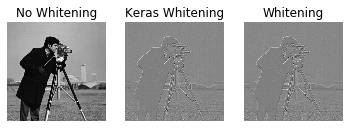

In [27]:
img = data.camera()
step_size = np.array([1,1])
window_size = np.array([5,5])

img_padded, pad_size = preprocessing.window_pad(img, window_size, step_size)
img_vectorized = np.transpose(preprocessing.vectorize_img(img_padded, window_size, step_size))
img_batches = img_vectorized.reshape((262144,5,5,1))
datagen = ImageDataGenerator(zca_whitening=True, zca_epsilon=1e-5)
datagen.fit(img_batches)
img_batches = datagen.standardize(img_batches)
img_vectorized = img_batches.reshape(262144, 25)
keras_whitened = preprocessing.imagize_vector(np.transpose(img_vectorized), img_padded.shape, window_size, step_size)
keras_whitened = preprocessing.undo_pad(keras_whitened, pad_size)
keras_normalized = 256*(keras_whitened - np.min(keras_whitened))/(np.max(keras_whitened)-np.min(keras_whitened))

brainlit_whitened, _ = preprocessing.whiten(img, window_size, step_size, centered=False, type='ZCA')
brainlit_normalized = 256*(brainlit_whitened - np.min(brainlit_whitened))/(np.max(brainlit_whitened)-np.min(brainlit_whitened))

plt.figure()
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("No Whitening")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(keras_normalized, cmap='gray')
plt.title("Keras Whitening")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(brainlit_normalized, cmap='gray')
plt.title("Whitening")
plt.axis('off')
plt.show()

The results are virtually identical, althought not exact.

In [29]:
print(np.sum(np.abs(keras_normalized - brainlit_normalized))/512**2)

0.07678596299698555
